## Содержание:
* [EDA](#first-bullet)
* [Baseline model](#baseline-bullet)
* [Тестирование модели](#test-bullet)
* [Профиль склонного к оттоку клиента](#profile-bullet)
* [Вывод](#summary-bullet)
* [Презентация модели 2 слайда](#pres-bullet)

**Model and analysys goal**

* В файле churn_train.txt собраны сэмпл данных по фактическому оттоку клиентов из компании за 3 месяца (month_number)

* По набору данных, необходимо построить модель, которая будет прогнозировать значение целевой переменной 'churn'.

* Подготовить небольшую презентацию (1-2 слайда), в которой аргументируется выбор модели. 

* Отдельно необходимо подготовить описательный профиль склонного к оттоку клиента, и его отличение от других клиентов.


In [53]:
import pandas as pd
import pandas_profiling
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.utils import shuffle, resample


from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder


from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_score


color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

## Первичный анализ данных EDA <a class="anchor" id="first-bullet"></a>

In [2]:
data = pd.read_csv('D:\Data Science\Тестовые\Сбер\churn_train.txt', sep='\t')

In [3]:
data.head(5)

client_id  month_number  age  lifetime beh_score              region  \
0      20201             2   38        21      2,73              Moscow   
1      42943             2   30        21      2,80              Moscow   
2      27570             1   48        13      2,80             Regions   
3      25037             3   40        15      2,68              Moscow   
4      47546             2   20        21      2,88  Saint-Petersbourgh   

  channel  avg_transaction_sum  total_products  deposit  is_package  \
0  Online                  345               1        1           1   
1  Branch                  269               1        1           1   
2  Online                  327               1        1           1   
3  Online                    0               1        1           1   
4  Branch                    0               1        1           0   

   salary_bucket  churn  
0        70000.0      0  
1        30000.0      0  
2       150000.0      1  
3        30000.0      0  
4       190000.0      0

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8305 entries, 0 to 8304
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   client_id            8305 non-null   int64  
 1   month_number         8305 non-null   int64  
 2   age                  8305 non-null   int64  
 3   lifetime             8305 non-null   int64  
 4   beh_score            8305 non-null   object 
 5   region               8305 non-null   object 
 6   channel              8305 non-null   object 
 7   avg_transaction_sum  8305 non-null   int64  
 8   total_products       8305 non-null   int64  
 9   deposit              8305 non-null   int64  
 10  is_package           8305 non-null   int64  
 11  salary_bucket        8304 non-null   float64
 12  churn                8305 non-null   int64  
dtypes: float64(1), int64(9), object(3)
memory usage: 843.6+ KB


Всего 8305 записей

Колонок по типу данных float64(1), int64(9), object(3)


In [5]:
data.describe()

client_id  month_number          age     lifetime  \
count   8305.000000   8305.000000  8305.000000  8305.000000   
mean   30030.098013      2.001686    39.411680    17.026008   
std    11554.802567      0.810722    10.519373     2.897835   
min    10005.000000      1.000000    18.000000    12.000000   
25%    20064.000000      1.000000    32.000000    15.000000   
50%    30069.000000      2.000000    38.000000    17.000000   
75%    39738.000000      3.000000    44.000000    20.000000   
max    49997.000000      3.000000    92.000000    22.000000   

       avg_transaction_sum  total_products      deposit   is_package  \
count          8305.000000     8305.000000  8305.000000  8305.000000   
mean            218.339675        1.534377     0.704034     0.517760   
std             169.282031        0.579062     0.456503     0.499715   
min               0.000000        1.000000     0.000000     0.000000   
25%               0.000000        1.000000     0.000000     0.000000   
50%             311.000000        1.000000     1.000000     1.000000   
75%             358.000000        2.000000     1.000000     1.000000   
max             501.000000        4.000000     1.000000     1.000000   

       salary_bucket        churn  
count    8304.000000  8305.000000  
mean    99926.541426     0.266827  
std     57532.939829     0.442328  
min         0.000000     0.000000  
25%     50000.000000     0.000000  
50%    100000.000000     0.000000  
75%    150000.000000     1.000000  
max    200000.000000     1.000000

In [6]:
# меняем string на float
data['beh_score'] = data['beh_score'].str.replace(',', '.').astype('float32')


In [7]:
data['channel'].value_counts()

Online    4537
Branch    3768
Name: channel, dtype: int64

In [8]:
# классы несбалансированы
data['churn'].value_counts(normalize=True) * 100

0    73.317279
1    26.682721
Name: churn, dtype: float64

In [9]:
data['region'].value_counts(normalize=True) * 100

Moscow                50.12643
Regions               24.99699
Saint-Petersbourgh    24.87658
Name: region, dtype: float64

In [10]:
# cvjnh
data.isna().sum()

client_id              0
month_number           0
age                    0
lifetime               0
beh_score              0
region                 0
channel                0
avg_transaction_sum    0
total_products         0
deposit                0
is_package             0
salary_bucket          1
churn                  0
dtype: int64

In [11]:
data = data.dropna()

In [12]:
data.duplicated().sum()

0

In [13]:
#удаляем выбросы
data = data[data['avg_transaction_sum'] > 0]

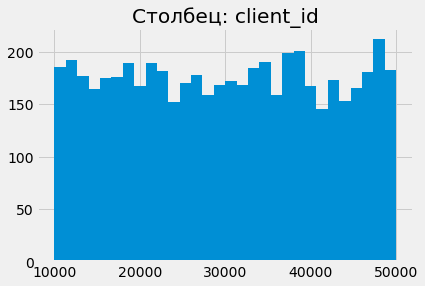

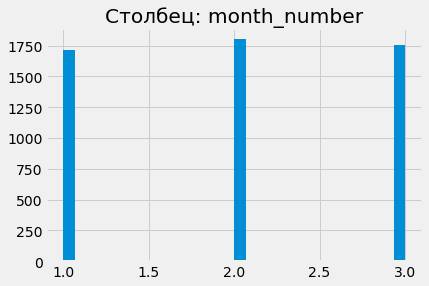

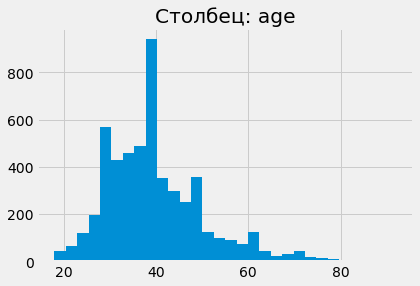

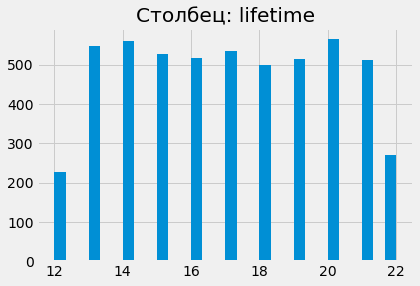

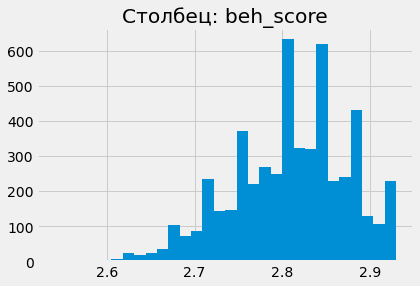

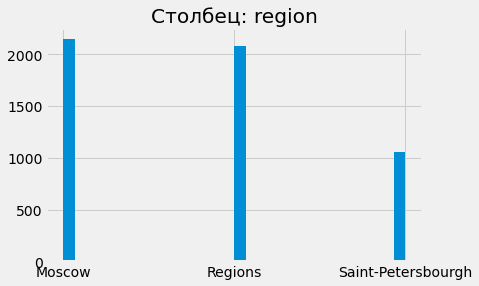

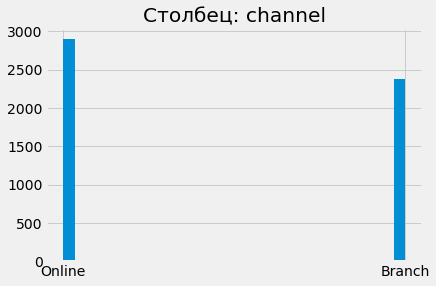

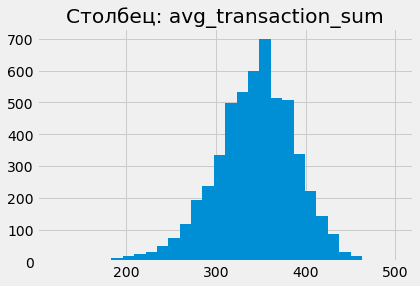

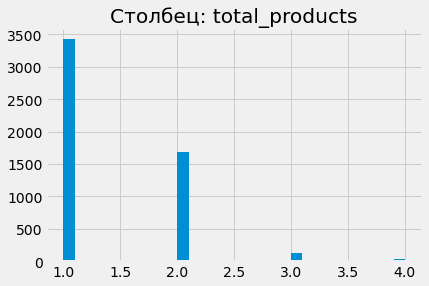

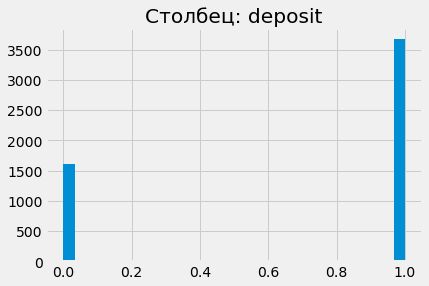

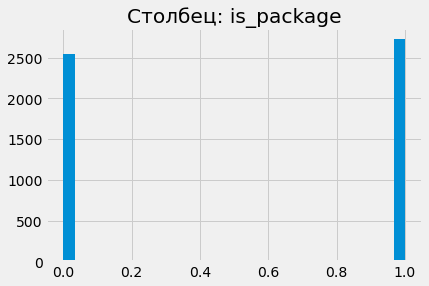

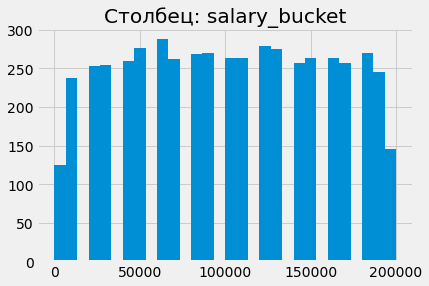

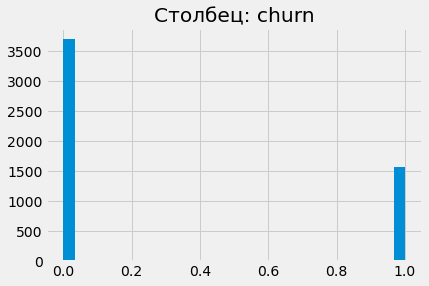

In [14]:
for col in data.columns:
    plt.hist(data[col], bins=30)
    plt.title(f'Столбец: {col}')
    plt.show()

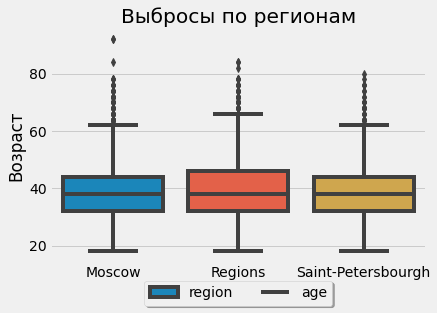

In [15]:
sns.boxplot(data=data, y="age", x="region")
plt.title('Выбросы по регионам')
plt.xlabel('Регион')
plt.ylabel('Возраст')
plt.legend(data[['region', 'age']], loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
plt.show()


#### Обработка аномальных значений

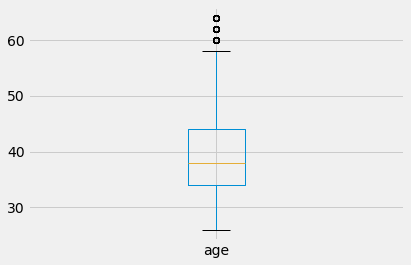

In [16]:
Q1 =  data['age'].quantile(0.025)
Q3 = data['age'].quantile(0.975)
IQR = Q3 - Q1
data = data[(data['age'] > Q1) & (data['age'] < Q3)]


data.boxplot(column="age")
plt.show()

Удаляем выбросы так как например в колонке age мах значение 92 года.

In [17]:
data['age'].describe()

count    4900.000000
mean       39.561224
std         8.648693
min        26.000000
25%        34.000000
50%        38.000000
75%        44.000000
max        64.000000
Name: age, dtype: float64

In [18]:
# формула для просмотра ecdf распределния
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Количество точет в datа: n
    n = len(data)
    # x-data
    x = np.sort(data)
    # y-data 
    y = np.arange(1, len(x)+1) / n
    return x, y

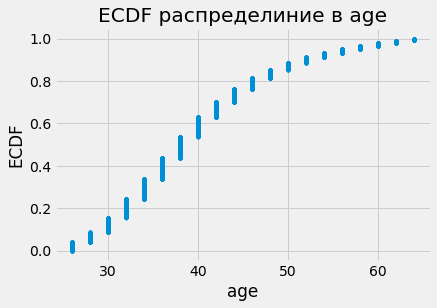

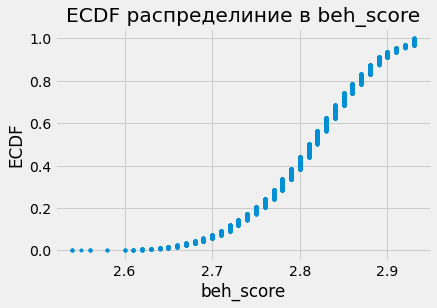

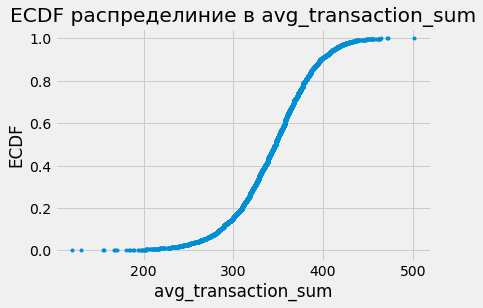

In [19]:
ecdf_col = ['age', 'beh_score', 'avg_transaction_sum']
for col in ecdf_col:
    x_month, y_month = ecdf(data[col]) 
    plt.plot(x_month, y_month, marker='.', linestyle='none') 
    plt.xlabel(f'{col}')
    plt.ylabel('ECDF')
    plt.title(f'ECDF распределиние в {col}')
    plt.show()

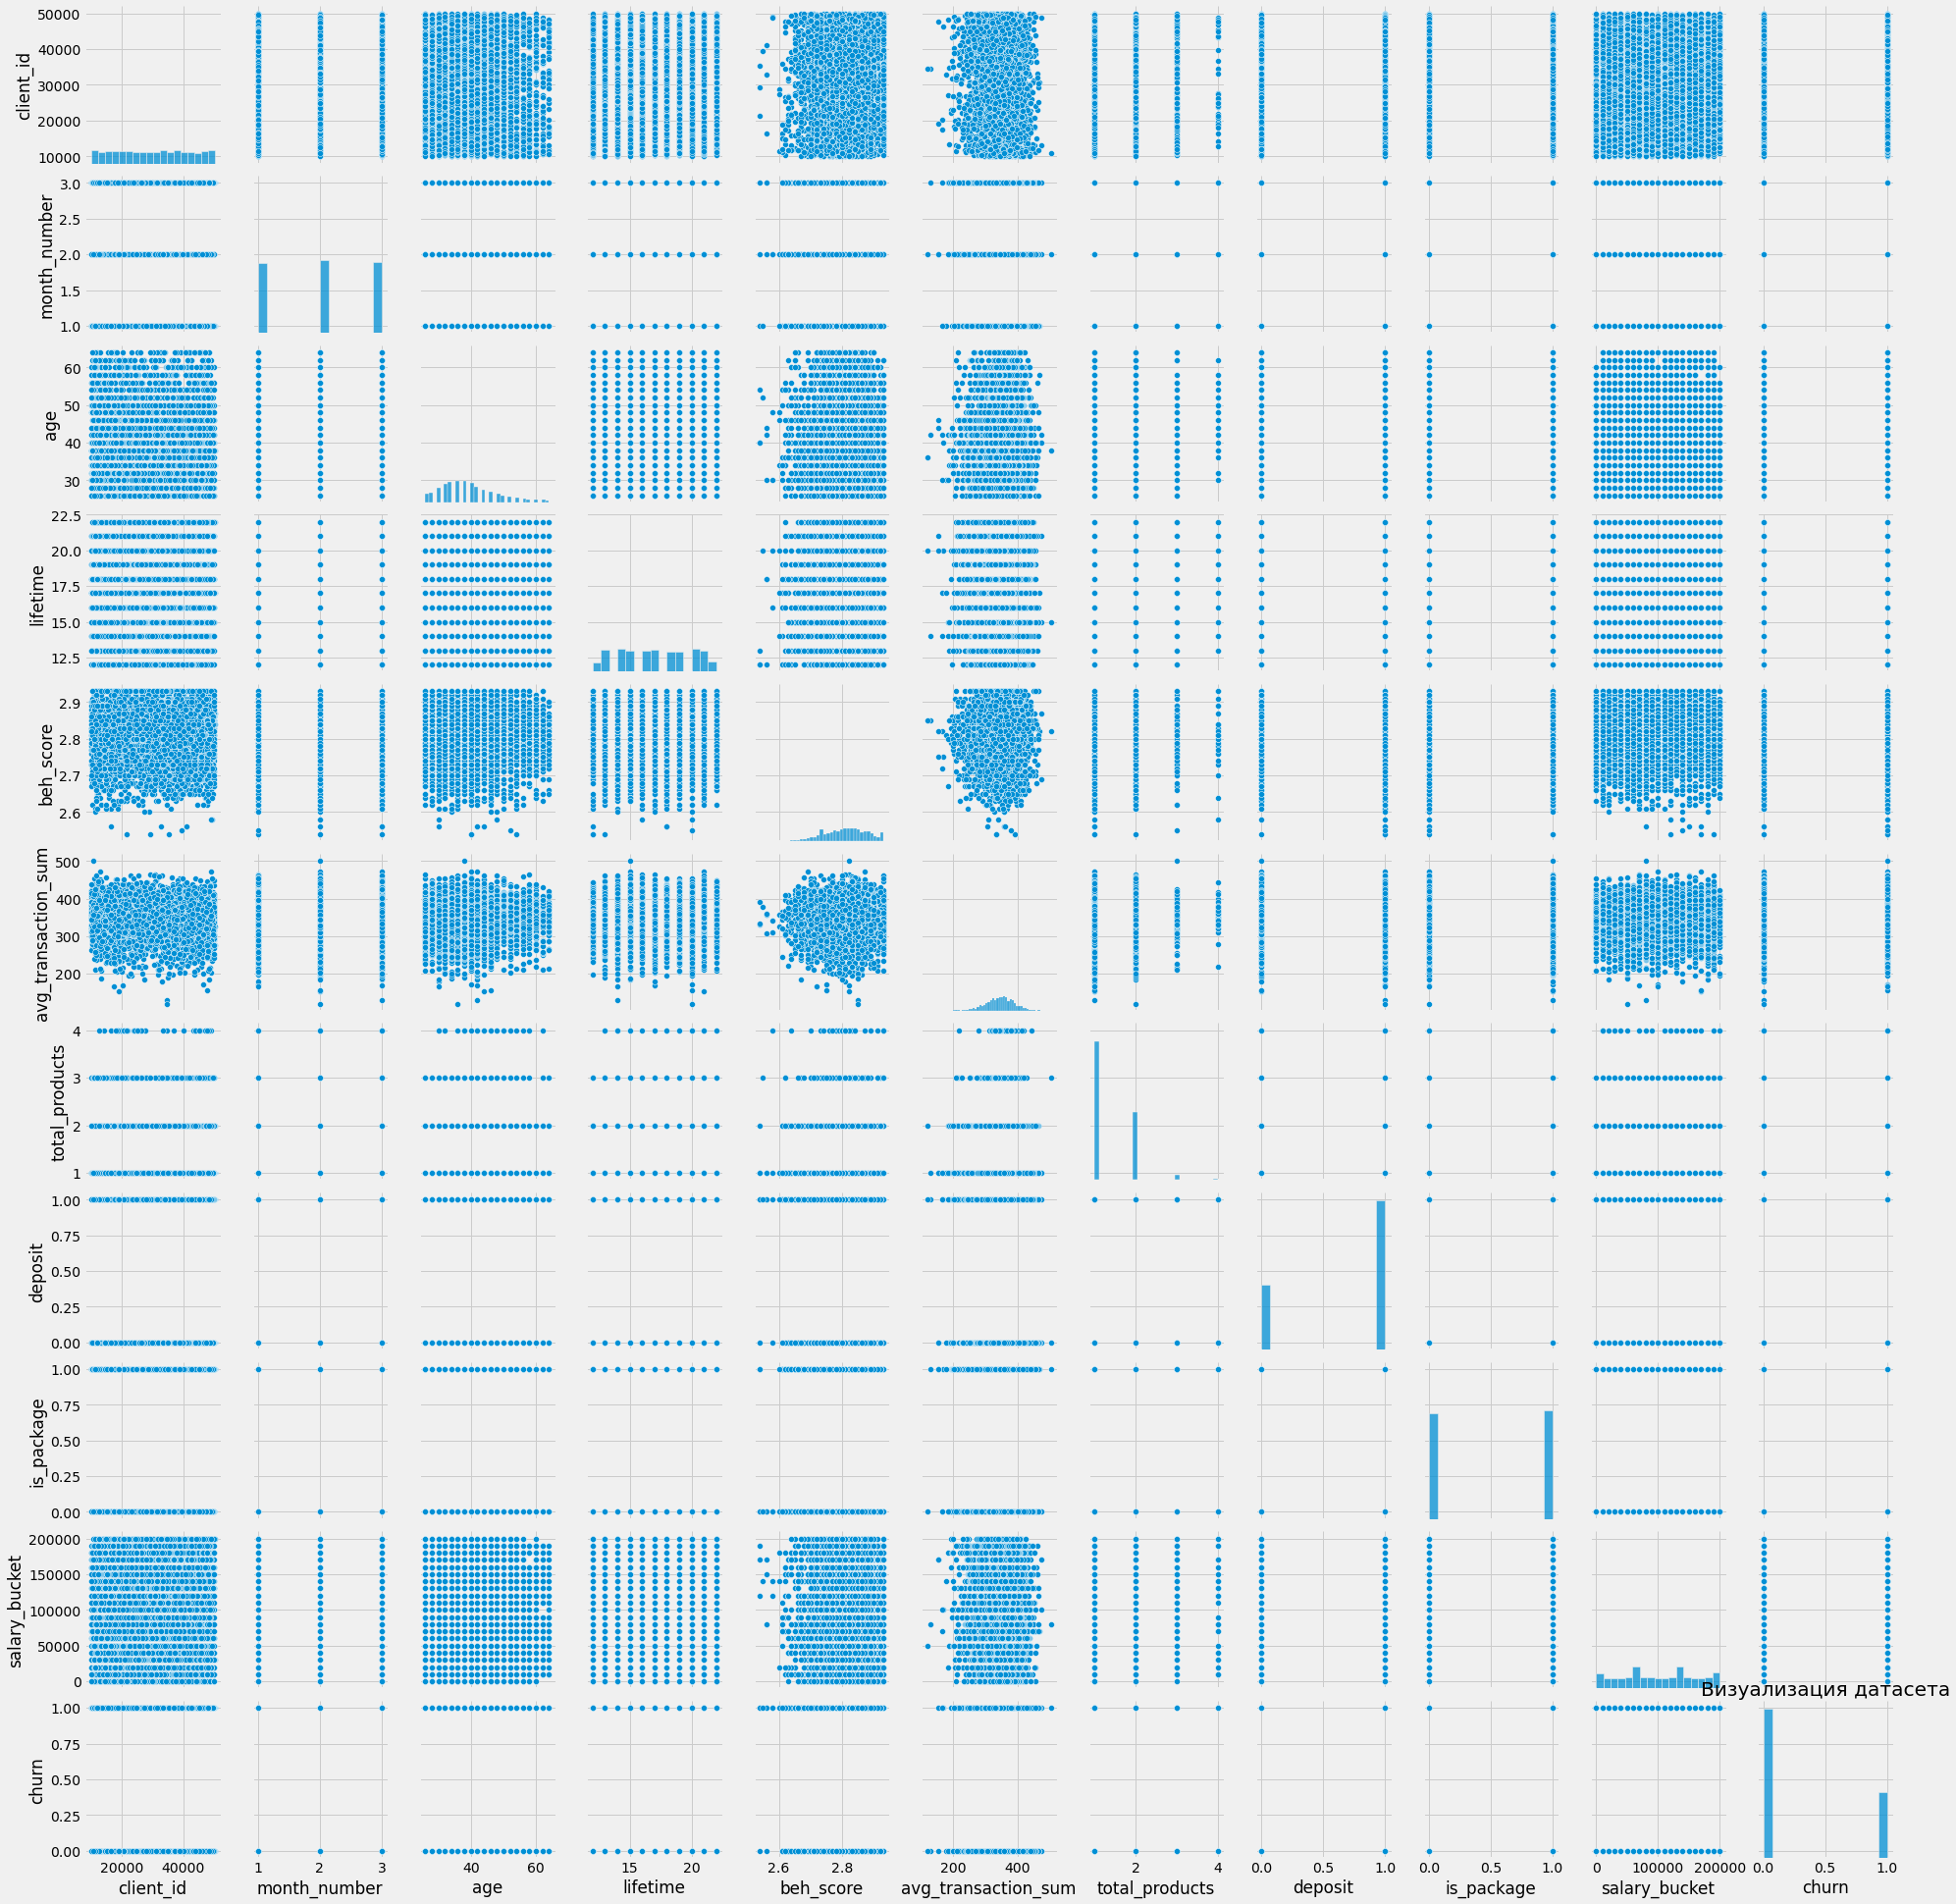

In [20]:
sns.pairplot(data)
plt.title('Визуализация датасета')
plt.show()

### Категоризация данных

Для salary_bucket создаем отдельную колонку с делением клиентов на классы для понимании сегментации, чтобы можно было уддобно отфильтровать или построить профайл клиента

In [21]:
def categorize_income(income):
    try:
        if 0 <= income <= 25000:
            return 'E'
        elif 25001 <= income <= 50000:
            return 'D'
        elif 50001 <= income <= 100000:
            return 'C'
        elif 100001 <= income <= 150000:
            return 'B'
        elif income >= 150001:
            return 'A'
    except:
        pass

In [22]:
data['salary_bucket_category'] = data['salary_bucket'].apply(categorize_income)

In [23]:
client_class = data['salary_bucket_category'].value_counts(normalize=True)
round(client_class * 100, 2)

C    25.84
B    25.47
A    22.16
D    14.86
E    11.67
Name: salary_bucket_category, dtype: float64

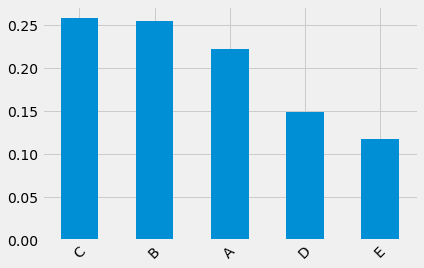

In [24]:
client_class.plot(kind='bar')
plt.xticks(rotation=45)
plt.show()

## Baseline model <a class="anchor" id="baseline-bullet"></a>


In [25]:
target = data['churn']
features = data.drop(['churn'], axis=1)

features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, stratify=target, test_size=0.30, random_state=12345)


print('Размер обучающей выборки - {}' .format(features_train.shape)) 
print('Размер валидоционной выборки - {}' .format(features_valid.shape)) 

Размер обучающей выборки - (3430, 13)
Размер валидоционной выборки - (1470, 13)


 Использую т.к классы не сбалансированые stratify=target

In [26]:
features_valid, features_test, target_valid, target_test= train_test_split(
    features_valid, target_valid, stratify=target_valid, test_size=0.5, random_state=12345)

print('Размер тестовой выборки - {}' .format(features_test.shape)) 
print('Размер валидоционной выборки - {}' .format(features_valid.shape)) 

Размер тестовой выборки - (735, 13)
Размер валидоционной выборки - (735, 13)


Исполузую pipiline, чтобы не было утечки данных

In [27]:
# разделяем числовые колонки и категориальные
numerical_features = ['client_id', 'month_number', 'age', 'lifetime', 'beh_score', 
        'avg_transaction_sum', 'total_products', 'deposit',
       'is_package', 'salary_bucket']

categorical_features =['region', 'channel', 'salary_bucket_category'] 



preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])
# Создаем pipeline для LogisticRegression
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear', random_state=12345))
])



# Создаем pipeline для RandomForestClassifier
pipe_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=12345))
])



# Создаем pipeline для RandomForestClassifier 
pipe_dt = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=12345))
])


In [28]:

rf_score = pipe_rf.fit(features_train, target_train).score(features_valid, target_valid)
predicted_valid_rf = pipe_rf.predict(features_valid)
print("F1 Случайный лес:", f1_score(target_valid, predicted_valid_rf))
print(f'ROC-AUC score {roc_auc_score(target_valid, predicted_valid_rf)}')

F1 Случайный лес: 0.4629629629629629
ROC-AUC score 0.6429488747553816


In [29]:
model = pipe.fit(features_train, target_train)
predicted_valid_lr = pipe.predict(features_valid)
print("F1 Логистческая регрессия:", f1_score(target_valid, predicted_valid_lr))
# Bassline model metrics: accuracy, precision, recall scores, AUC
print("Accuracy:", accuracy_score(target_valid, predicted_valid_lr))
print("Precision:", precision_score(target_valid, predicted_valid_lr))
print("Recall:", recall_score(target_valid, predicted_valid_lr))
print(f'ROC-AUC score {roc_auc_score(target_valid, predicted_valid_lr)}')

F1 Логистческая регрессия: 0.3846153846153846
Accuracy: 0.7387755102040816
Precision: 0.6818181818181818
Recall: 0.26785714285714285
ROC-AUC score 0.6065313111545988


In [30]:
dt_score = pipe_dt.fit(features_train, target_train).score(features_valid, target_valid) # используем метод score из библиотеки sklearn
predicted_valid_dt = pipe_dt.predict(features_valid)
print("F1 Дерево решений:", f1_score(target_valid, predicted_valid_dt)) # находим метрику F1
print("Accuracy:", accuracy_score(target_valid, predicted_valid_dt))
print("Precision:", precision_score(target_valid, predicted_valid_dt))
print("Recall:", recall_score(target_valid, predicted_valid_dt))
print(f'ROC-AUC score {roc_auc_score(target_valid, predicted_valid_dt)}')

F1 Дерево решений: 0.41425389755011144
Accuracy: 0.6421768707482993
Precision: 0.41333333333333333
Recall: 0.41517857142857145
ROC-AUC score 0.5784307729941291


## Баланс классов

In [31]:
# попробуем увеличить выборку для баланса классов
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 2)

In [32]:
target_upsampled.value_counts(normalize=True)

0    0.533304
1    0.466696
Name: churn, dtype: float64

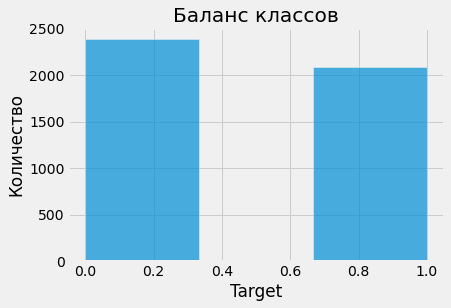

In [33]:
sns.histplot(data=target_upsampled, bins=3, alpha=0.7)
plt.title('Баланс классов')
plt.xlabel('Target')
plt.ylabel('Количество')
plt.show()

In [34]:
#model_rf = RandomForestClassifier(max_depth=11, n_estimators=190, min_samples_leaf=3, random_state=12345)
pipe_rf.fit(features_upsampled, target_upsampled)
predicted_valid = pipe_rf.predict(features_valid)
print("F1 Случайный лес:", f1_score(target_valid, predicted_valid))
print(f'ROC-AUC score {roc_auc_score(target_valid, predicted_valid)}')

F1 Случайный лес: 0.4623955431754875
ROC-AUC score 0.6343872309197652


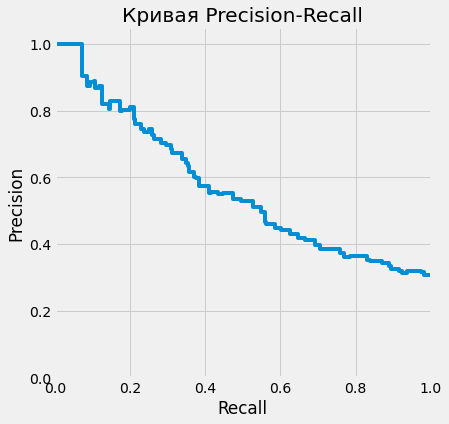

In [35]:
probabilities_valid =pipe_rf.predict_proba(features_valid)
precision, recall, thresholds = precision_recall_curve(target_valid, probabilities_valid[:, 1])

plt.figure(figsize=(6, 6))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Кривая Precision-Recall')
plt.show() 

In [36]:
probabilities_valid = pipe_rf.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

for threshold in np.arange(0, 0.5, 0.02):
    predicted_valid = probabilities_one_valid > threshold
    precision = precision_score(target_valid, predicted_valid)  
    recall = recall_score(target_valid, predicted_valid) 

    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}".format(
        threshold, precision, recall))

Порог = 0.00 | Точность = 0.305, Полнота = 1.000
Порог = 0.02 | Точность = 0.305, Полнота = 1.000
Порог = 0.04 | Точность = 0.305, Полнота = 1.000
Порог = 0.06 | Точность = 0.306, Полнота = 1.000
Порог = 0.08 | Точность = 0.307, Полнота = 1.000
Порог = 0.10 | Точность = 0.307, Полнота = 0.991
Порог = 0.12 | Точность = 0.308, Полнота = 0.987
Порог = 0.14 | Точность = 0.315, Полнота = 0.982
Порог = 0.16 | Точность = 0.319, Полнота = 0.973
Порог = 0.18 | Точность = 0.320, Полнота = 0.924
Порог = 0.20 | Точность = 0.326, Полнота = 0.902
Порог = 0.22 | Точность = 0.342, Полнота = 0.888
Порог = 0.24 | Точность = 0.353, Полнота = 0.839
Порог = 0.26 | Точность = 0.362, Полнота = 0.786
Порог = 0.28 | Точность = 0.384, Полнота = 0.759
Порог = 0.30 | Точность = 0.396, Полнота = 0.705
Порог = 0.32 | Точность = 0.419, Полнота = 0.665
Порог = 0.34 | Точность = 0.442, Полнота = 0.625
Порог = 0.36 | Точность = 0.461, Полнота = 0.585
Порог = 0.38 | Точность = 0.496, Полнота = 0.558
Порог = 0.40 | Точно

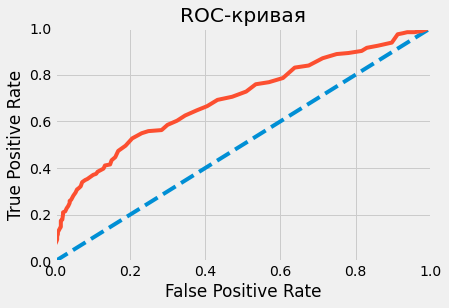

In [54]:
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)                

plt.figure()


# ROC-кривая случайной модели 
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)


plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title("ROC-кривая")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.savefig('RF_roc_score.png')

plt.show()

In [38]:
# params = {"max_depth": [3, None],                     
#           "max_features": sp_randint(1, 11),          
#           "min_samples_split": sp_randint(2, 11),     
#           "bootstrap": [True, False],                 
#           "criterion": ["gini", "entropy"]}           

# # Использую RandomSearch + CV для выбора гиперпараметров
# n_iter_search = 20
# random_search = RandomizedSearchCV(pipe_rf, param_distributions=params,
#                                    n_iter=n_iter_search, cv=5)
# random_search.fit(features_upsampled, target_upsampled)

## Тестирование модели <a class="anchor" id="test-bullet"></a>

In [39]:
pipe_rf_test = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(max_depth=10, n_estimators=50, min_samples_leaf=5, random_state=12345))
])

pipe_rf_test.fit(features_upsampled, target_upsampled)
predicted_test = pipe_rf_test.predict(features_test)
print("F1 Случайного леса:", f1_score(target_test, predicted_test))
print("Accuracy:", accuracy_score(target_test, predicted_test))
print("Precision:", precision_score(target_test, predicted_test))
print("Recall:", recall_score(target_test, predicted_test))
print(f'ROC-AUC score {roc_auc_score(target_test, predicted_test)}')

F1 Случайного леса: 0.5336658354114713
Accuracy: 0.745578231292517
Precision: 0.6045197740112994
Recall: 0.47767857142857145
ROC-AUC score 0.6703461350293541


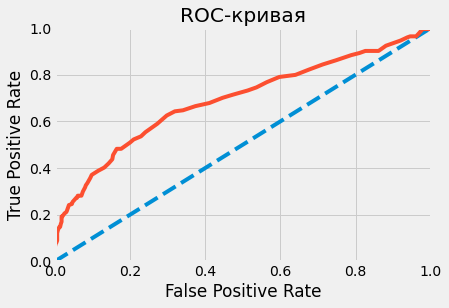

In [40]:
probabilities_test = pipe_rf.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)                

plt.figure()


# ROC-кривая случайной модели 
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)


plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title("ROC-кривая")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.show()

In [41]:
# roc auc расчет метрики
roc_auc_score(target_test, probabilities_one_test)

0.6912959533128319

In [42]:
# можно улучшить модель убирая слабые признаки
pipe_rf.steps[1][1].feature_importances_

array([0.1407516 , 0.04078203, 0.16117718, 0.08729992, 0.11307492,
       0.13799528, 0.05963413, 0.02210946, 0.02747768, 0.08858322,
       0.01425405, 0.01539083, 0.01286289, 0.01117377, 0.01095522,
       0.01083048, 0.01315912, 0.01380562, 0.0102742 , 0.0084084 ])

## Профайл клиента <a class="anchor" id="profile-bullet"></a>

In [43]:
probabilities_test = pipe_rf.predict_proba(features_test)
#probabilities_one_test = probabilities_test[:, 1]

# нахожу индексы клиетов кто выше порога и вероятность того, что они поподут в предсказание churn
churn_indices = np.where(probabilities_test[:, 1] > 0.67)

churn_clients = data.iloc[churn_indices]

In [44]:
churn_clients.head(5)

client_id  month_number  age  lifetime  beh_score              region  \
41       12061             1   38        21       2.83              Moscow   
53       49359             1   34        19       2.78  Saint-Petersbourgh   
84       18206             3   32        12       2.77             Regions   
139      13601             3   34        21       2.83             Regions   
185      16257             3   28        13       2.75              Moscow   

    channel  avg_transaction_sum  total_products  deposit  is_package  \
41   Branch                  350               1        1           0   
53   Online                  376               2        1           0   
84   Branch                  305               1        1           0   
139  Branch                  291               2        0           1   
185  Online                  391               1        1           0   

     salary_bucket  churn salary_bucket_category  
41        130000.0      0                      B  
53         50000.0      0                      D  
84             0.0      0                      E  
139       200000.0      0                      A  
185       180000.0      0                      A

In [45]:
# проводим анализ данных
churn_clients.profile_report()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [46]:
# смотри больше всего по классам
churn_clients['salary_bucket_category'].value_counts()

C    18
B    14
A     9
D     8
E     8
Name: salary_bucket_category, dtype: int64

**Верояность большая у класса С, B чуть меньше**

In [47]:
churn_clients['age'].value_counts().head(5)

38    8
34    7
28    5
40    4
36    3
Name: age, dtype: int64

**Клиенты в возрасте от 28 имеют риск к оттоку, а с 34-40 риск большой.**

In [48]:
churn_clients['avg_transaction_sum'].value_counts().head(5)

355    3
346    2
391    2
351    2
323    2
Name: avg_transaction_sum, dtype: int64

In [49]:
churn_clients['salary_bucket'].value_counts().head(5)

60000.0     6
100000.0    6
50000.0     6
10000.0     4
110000.0    4
Name: salary_bucket, dtype: int64

**Xарактерна зарплата от 10000 до 100000 рублей**

In [50]:
churn_clients['channel'].value_counts()

Online    31
Branch    26
Name: channel, dtype: int64

In [51]:
churn_clients['region'].value_counts()

Regions               23
Moscow                21
Saint-Petersbourgh    13
Name: region, dtype: int64

**В регионах и Москве отказавшихся клиентов больше**

In [52]:
churn_clients['total_products'].value_counts()

1    42
2    15
Name: total_products, dtype: int64

**У таких клиетов, есть только один банковский продукт**

## Вывод <a class="anchor" id="summary-bullet"></a>

**Клиент**

* Клиенты в возрасте от 28 имеют повышенный риск к оттоку, а с 34-40 риск еще больше. 
* У таких клиетов, есть только один банковский продукт
* Проживают регионах и Москве
* С зарплатой от 10000 до 100000 рублей

**Улучшить модель можно:**


* Метрика ROC-AUC 0.67 показывает результат лучше чем случайный выбор, но модель можно доработать.
* убрать слабые признаки, выбрать признаки с хорошим значением, через feature_importance или например метод Shap. Так же можно сделать новые признаки.
* Провести подбор гиперпараметров через GridSearch или RandomizedSearchCV. Или попробовать кросс валидацию
* Попробовать другие модели для задачи классификации, как Gradient Boosting or XGBoost


## Презентация модели <a class="anchor" id="pres-bullet"></a>

Слайд 1: Введение

**Классификатор случайного леса для проблемы оттока**

Производительность модели с показателем ROC-AUC 0,67
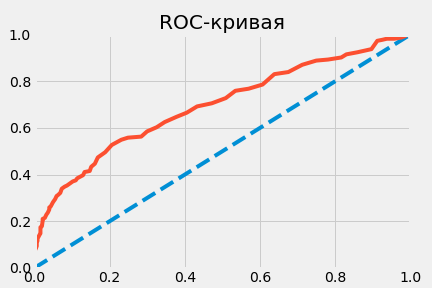

Слайд 2: Преимущества и улучшение

Классификатор случайного леса является методом ансамбля, который сочетает несколько деревьев решений для совершения прогнозов, что улучшает точность модели и снижает переобучение

Модель способна обрабатывать высокоизмеримые и категориальные данные, что делает ее очень подходящей для проблемы оттока
Классификатор случайного леса также имеет возможность определять важные признаки, которые способствуют прогнозированию , что может предоставлять ценные выводы для бизнес-решений

Провести подбор гиперпараметров через GridSearch или RandomizedSearchCV. 

Попробовать другие модели для задачи классификации, как Gradient Boosting or XGBoost